In this dataframe, I will check the rfmix run in which I include the males (all samples present).

In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from glob import glob

In [2]:
def length_to_windows(length_df, pops, window_size=1000000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_all_reanalyze5/"

In [4]:
input_file = rfmix_path + "chr8.msp.tsv"
chr8_test = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [5]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [6]:
df_l = []
for hap in chr8_test.columns[6:]:
    df_l.append(create_paint_df_ind(chr8_test, hap, number_subpop_mapping, north_south_mapping))
length_df_8 = pd.concat(df_l)

In [7]:
sampling_locations_c = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].C_origin.unique()
sampling_locations_o = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].Origin.unique()


In [8]:
location_l = []
for sampling_location in sampling_locations_o:
    samples = meta_data_samples.loc[(meta_data_samples.Origin == sampling_location)].PGDP_ID
    s_df = length_df_8.loc[length_df_8.individual.isin(samples)]
    s_df = s_df.groupby("pos").mean().reset_index()
    s_df["Origin"] = sampling_location
    #s_df["C_origin"] = sampling_locations_c
    
    location_l.append(s_df)
location_df_8 = pd.concat(location_l)

In [9]:
location_df_8

,pos,end_pos,length,n/s,Origin
0,4218,225310.0,221093.0,0.0,"Mikumi, Tanzania"
1,225311,228947.0,3637.0,0.0,"Mikumi, Tanzania"
2,228948,603021.0,374074.0,0.0,"Mikumi, Tanzania"
3,603022,603224.0,203.0,0.0,"Mikumi, Tanzania"
4,603225,1346442.0,743218.0,0.0,"Mikumi, Tanzania"
...,...,...,...,...,...
464,138618233,138619025.0,793.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
465,138619026,138619726.0,701.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
466,138619727,139468550.0,848824.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
467,139468551,140272623.0,804073.0,1.0,"Gog Woreda, Gambella region, Ethiopia"


In [10]:
loc_df = location_df_8

#olive_tanzania = loc_df.loc[loc_df.Origin == "Anubis, Tanzania"]
#eastern_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Central Tanzania"]
#western_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Western Tanzania"]

serengeti = loc_df.loc[loc_df.Origin == "Serengeti, Tanzania"]
tarangire = loc_df.loc[loc_df.Origin == "Tarangire, Tanzania"]
gog = loc_df.loc[loc_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = loc_df.loc[loc_df.Origin == "Gombe, Tanzania"]
mikumi = loc_df.loc[loc_df.Origin == "Mikumi, Tanzania"]
ruaha = loc_df.loc[loc_df.Origin == "Ruaha, Tanzania"]
mahale = loc_df.loc[loc_df.Origin == "Mahale, Tanzania"]
issa = loc_df.loc[loc_df.Origin == "Issa Valley, Tanzania"]
manyara = loc_df.loc[loc_df.Origin == "Lake Manyara, Tanzania"]
katavi = loc_df.loc[loc_df.Origin == "Katavi, Tanzania"]

In [11]:
katavi

,pos,end_pos,length,n/s,Origin
0,4218,225310.0,221093.0,0.0,"Katavi, Tanzania"
1,225311,228947.0,3637.0,0.0,"Katavi, Tanzania"
2,228948,603021.0,374074.0,0.0,"Katavi, Tanzania"
3,603022,603224.0,203.0,0.0,"Katavi, Tanzania"
4,603225,1346442.0,743218.0,0.0,"Katavi, Tanzania"
...,...,...,...,...,...
464,138618233,138619025.0,793.0,0.0,"Katavi, Tanzania"
465,138619026,138619726.0,701.0,0.0,"Katavi, Tanzania"
466,138619727,139468550.0,848824.0,0.0,"Katavi, Tanzania"
467,139468551,140272623.0,804073.0,0.0,"Katavi, Tanzania"


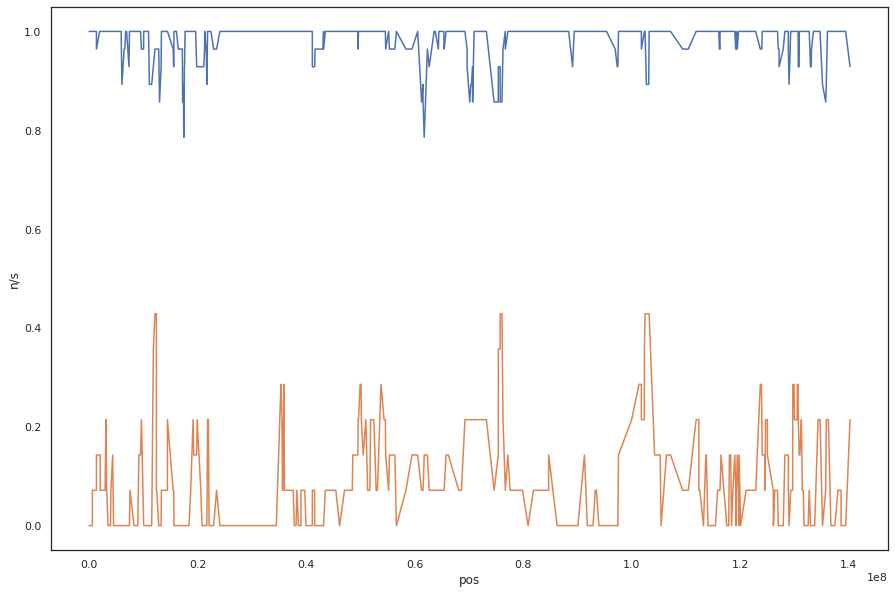

In [12]:
plt.figure(figsize=(15,10))
g = sns.lineplot(data=serengeti, x="pos", y="n/s")
g = sns.lineplot(data=mahale, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


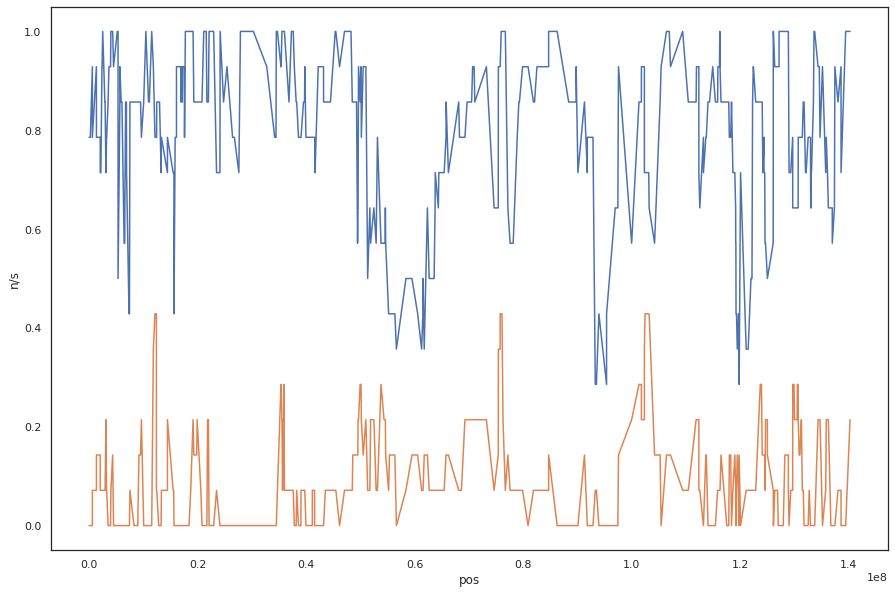

In [13]:
plt.figure(figsize=(15,10))
g = sns.lineplot(data=tarangire, x="pos", y="n/s")
g = sns.lineplot(data=mahale, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


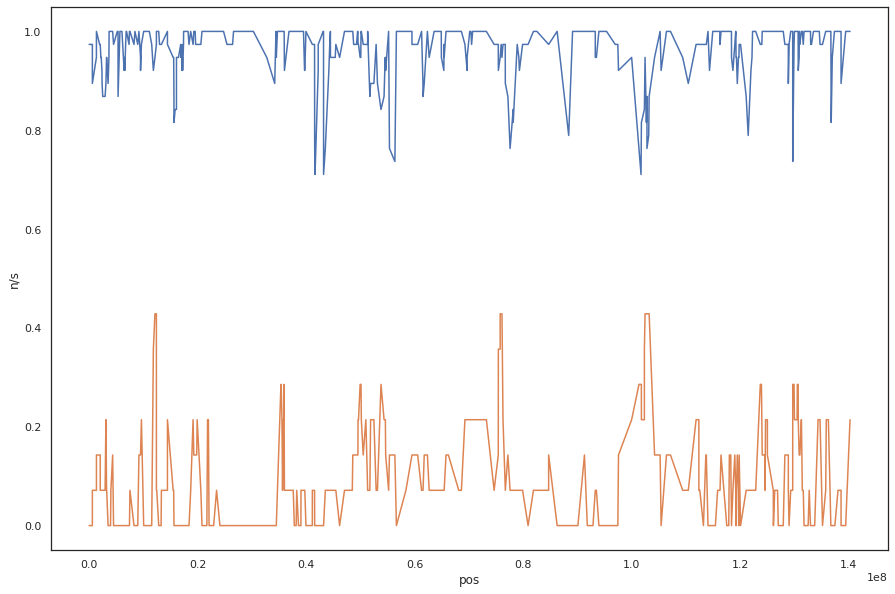

In [14]:
plt.figure(figsize=(15,10))
g = sns.lineplot(data=manyara, x="pos", y="n/s")
g = sns.lineplot(data=mahale, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


In [15]:
stats.spearmanr(manyara["n/s"], mahale["n/s"])

SpearmanrResult(correlation=-0.15530048750325448, pvalue=0.0007387663725283092)

Spearman across all completed chromosomes.

In [16]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_all_reanalyze5/"
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}
sampling_locations_c = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus",
                                                                             "anubis"])].C_origin.unique()
sampling_locations_o = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus",
                                                                             "anubis"])].Origin.unique()


In [17]:
paths = glob(rfmix_path + "chr*.msp.tsv")

In [18]:
paths[0].split("/")[-1].split(".")[0][3:]

'16'

In [19]:
df_l = []
for chrom_path in paths: #+["X"]:
    chr_df = pd.read_csv(chrom_path, sep = "\t", header=1)
    chr_nr = chrom_path.split("/")[-1].split(".")[0][3:]
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "chr{}".format(chr_nr)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

In [20]:
location_l = []
for sampling_location in sampling_locations_o:
    samples = meta_data_samples.loc[(meta_data_samples.Origin == sampling_location)].PGDP_ID
    s_df = length_df.loc[length_df.individual.isin(samples)]
    s_df = s_df.groupby(["chrom","pos"]).mean().reset_index()
    s_df["Origin"] = sampling_location
    #s_df["C_origin"] = sampling_locations_c
    
    location_l.append(s_df)
location_df_all = pd.concat(location_l)

In [21]:
loc_df = location_df_all

#olive_tanzania = loc_df.loc[loc_df.Origin == "Anubis, Tanzania"]
#eastern_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Central Tanzania"]
#western_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Western Tanzania"]

serengeti = loc_df.loc[loc_df.Origin == "Serengeti, Tanzania"]
tarangire = loc_df.loc[loc_df.Origin == "Tarangire, Tanzania"]
gog = loc_df.loc[loc_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = loc_df.loc[loc_df.Origin == "Gombe, Tanzania"]
mikumi = loc_df.loc[loc_df.Origin == "Mikumi, Tanzania"]
ruaha = loc_df.loc[loc_df.Origin == "Ruaha, Tanzania"]
mahale = loc_df.loc[loc_df.Origin == "Mahale, Tanzania"]
issa = loc_df.loc[loc_df.Origin == "Issa Valley, Tanzania"]
manyara = loc_df.loc[loc_df.Origin == "Lake Manyara, Tanzania"]
katavi = loc_df.loc[loc_df.Origin == "Katavi, Tanzania"]

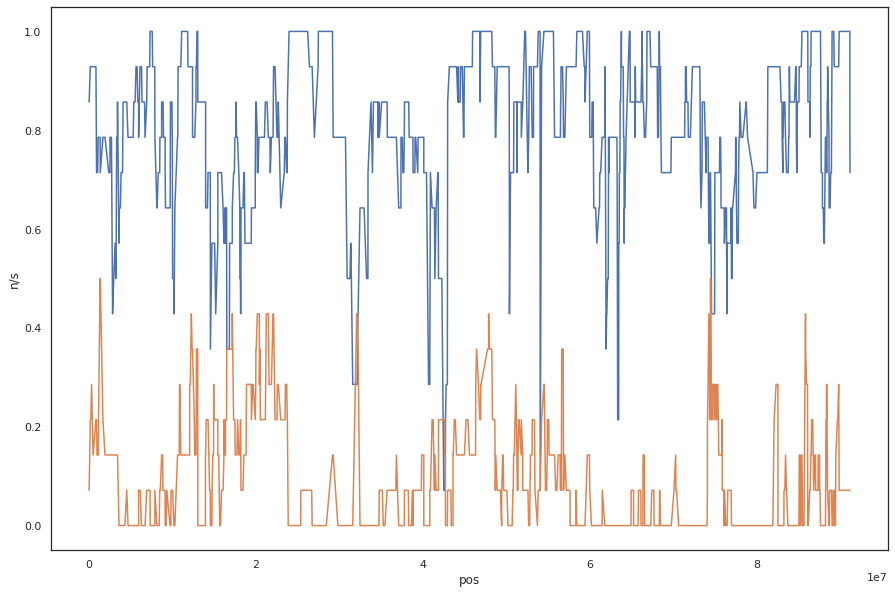

In [25]:
chrom = "chr10"
n_df = tarangire
s_df = mahale

n_df = n_df.loc[n_df.chrom == chrom]
s_df = s_df.loc[s_df.chrom == chrom]

plt.figure(figsize=(15,10))
g = sns.lineplot(data=n_df, x="pos", y="n/s")
g = sns.lineplot(data=s_df, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


In [23]:
stats.spearmanr(tarangire["n/s"], mahale["n/s"])

SpearmanrResult(correlation=0.01087054498185552, pvalue=0.10411918832010773)